In [1]:
import torch
from PIL import Image

from lavis.models import load_model_and_preprocess

/home/lijun07/miniconda3/envs/LAVIS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load an example image

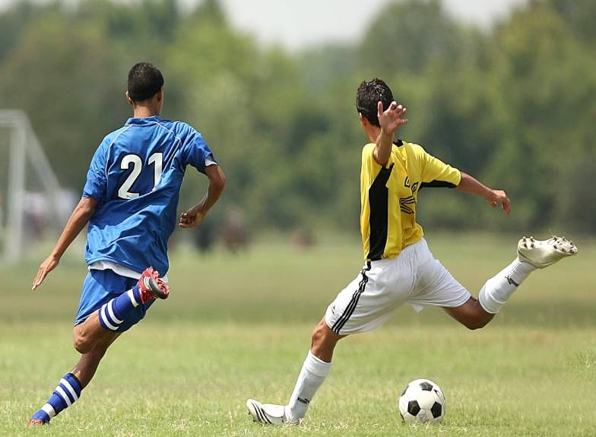

In [2]:
raw_image = Image.open("../docs/_static/football.png").convert("RGB")
display(raw_image.resize((596, 437))) 

In [3]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Load BLIP VQA model finetuned on VQAv2

In [6]:
import os
os.environ['TRANSFORMERS_OFFLINE']='1'
model, vis_processors, txt_processors = load_model_and_preprocess(name="blip2_beit3_t5", model_type="pretrain_flant5b", is_eval=True, device=device)

load from /data/BLIP2/Pretrain_stage2/beit3+t5base/20230328203/checkpoint_19.pth


In [7]:
vis_processors.keys()

dict_keys(['train', 'eval'])

In [8]:
txt_processors.keys()

dict_keys(['train', 'eval'])

In [27]:
question = "What season should the scene in the picture be in?"

In [28]:
# use "eval" processors for inference
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
question = txt_processors["eval"](question)

samples = {"image": image, "text_input": question}

#### generative question answering

In [29]:
model.predict_answers(samples=samples, inference_method="generate")

['winter']

#### ranking-based question answering

In [10]:
# rank answer candidates by their likelihood and return the best answer
answer_candidates = ["Singapore", "London", "Palo Alto", "Tokyo"]

model.predict_answers(samples, answer_list=answer_candidates, inference_method="rank")

['London']

#### Ask questions in batch

In [12]:
batch_size = 3

# create a batch of samples, could be multiple images or copies of the same image
image_batch = image.repeat(batch_size, 1, 1, 1)

# create a batch of questions, make sure the number of questions matches the number of images
question_1 = txt_processors["eval"]("Which city is this photo taken?")
question_2 = txt_processors["eval"]("What time is this during the day?")
question_3 = txt_processors["eval"]("Is it Singapore or London?")

question_batch = [question_1, question_2, question_3]

model.predict_answers(samples={"image": image_batch, "text_input": question_batch}, inference_method="generate")


['London', 'morning', 'Singapore']